In [1]:
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "C:\\Users\\91952\\AppData\\Roaming\\gcloud\\application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

In [41]:
testQuery = """
SELECT BlockGroupCode,
       deploymentRate21 - deploymentRate15 AS deploymentRateDiff,
       pop / NULLIF(landArea, 0) AS popDensity,
       houseRoadDensity,
       unemploymentRate,
       houseOwnerRate,
       maleRate,
       ageUnder17Rate,
       ageBetween18and24Rate,
       ageAbove65Rate,
       income AS medianIncome,
       aboveHighSchoolRate,
       aboveBachelorRate,
       whiteRate,
       MovedIn1yearRate,
       newlyMovedRate,
       demRatio,
       IFNULL(HadFund, 0) AS hadFund,
       avgAnnualTemp
FROM `broadband-data.capstone.blockgroup_2020_normal`
LEFT JOIN `broadband-data.usac_high_cost.Block_Group_Code_2015_2021` ON BlockGroupCode = Census_Block_Group_Code
WHERE SUBSTR(BlockGroupCode, 1, 2) != "02" and SUBSTR(BlockGroupCode, 1, 2) != "15"
"""

# Runs the query and converts it into a dataframe
df = client.query(testQuery).to_dataframe()

In [42]:
df = df.dropna()
df = df.astype({'medianIncome': 'int32'})
df = df.astype({'hadFund': 'int32'})
df.describe()

,deploymentRateDiff,popDensity,houseRoadDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,demRatio,hadFund,avgAnnualTemp
count,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000,201559.000000
mean,0.084352,6360.243891,0.063022,0.056733,0.654726,0.490640,0.216386,0.088180,0.169931,69307.009709,0.875007,0.306300,0.734069,0.136553,0.048641,0.535687,0.191180,14.010711
std,0.222527,15292.628235,1.038553,0.059434,0.259184,0.061114,0.086207,0.079370,0.102449,37759.284285,0.117126,0.207901,0.261740,0.105062,0.061517,0.217279,0.393231,4.496616
min,-0.980392,0.044621,0.000014,0.000000,0.000000,0.034354,0.000000,0.000000,0.000000,2500.000000,0.045936,0.000000,0.000000,0.000000,0.000000,0.003142,0.000000,-0.510687
25%,0.000000,473.639711,0.013253,0.017408,0.488571,0.455796,0.161961,0.046805,0.101873,43688.000000,0.826638,0.145154,0.604572,0.062161,0.007348,0.368890,0.000000,10.498495
50%,0.000000,2685.990338,0.032827,0.041607,0.715935,0.491269,0.216849,0.074586,0.154455,60694.000000,0.909457,0.254697,0.826225,0.112355,0.028786,0.530177,0.000000,13.066739
75%,0.021624,6222.222222,0.057343,0.077670,0.864294,0.525039,0.270578,0.108891,0.215739,85313.000000,0.959285,0.431206,0.939429,0.184505,0.066787,0.700893,0.000000,17.595718
max,1.000000,639500.000000,444.604461,1.000000,1.000000,1.000000,0.776620,0.996759,1.000000,250000.000000,1.000000,1.000000,1.000000,1.000000,0.939583,0.999960,1.000000,25.395627


In [43]:
df = df.dropna()
df = df.astype({'medianIncome': 'int32'})
df = df.astype({'hadFund': 'int32'})
for column in df:
    #if column == 'popDensity':
    #    df[column] = df[column].clip(upper=60000)
    #if column == 'houseRoadDensity':
    #    df[column] = df[column].clip(upper=1)
    if column != 'BlockGroupCode' and column != 'deploymentRateDiff' and column != 'hadFund':
        df[column] = (df[column] - df[column].mean()) / df[column].std()
        #df[column] = df[column] / (df[column].max() - df[column].min())
df.describe()

,deploymentRateDiff,popDensity,houseRoadDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,demRatio,hadFund,avgAnnualTemp
count,201559.000000,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,201559.000000,2.015590e+05
mean,0.084352,-6.472330e-17,8.971722e-18,1.367791e-16,-1.072799e-15,-5.761643e-16,4.044149e-16,-2.256150e-17,-1.128075e-17,-2.707380e-17,2.899153e-16,-2.876591e-16,-1.568024e-16,4.061070e-17,-1.725955e-16,-3.040162e-16,0.191180,-9.701445e-17
std,0.222527,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.393231,1.000000e+00
min,-0.980392,-4.158997e-01,-6.066838e-02,-9.545499e-01,-2.526108e+00,-7.466161e+00,-2.510086e+00,-1.110991e+00,-1.658689e+00,-1.769287e+00,-7.078468e+00,-1.473301e+00,-2.804569e+00,-1.299735e+00,-7.906905e-01,-2.450976e+00,0.000000,-3.229406e+00
25%,0.000000,-3.849308e-01,-4.792107e-02,-6.616525e-01,-6.410703e-01,-5.701467e-01,-6.313289e-01,-5.212822e-01,-6.643113e-01,-6.784824e-01,-4.129709e-01,-7.751128e-01,-4.947519e-01,-7.080791e-01,-6.712394e-01,-7.676642e-01,0.000000,-7.810800e-01
50%,0.000000,-2.402631e-01,-2.907371e-02,-2.545004e-01,2.361601e-01,1.029493e-02,5.365217e-03,-1.712737e-01,-1.510577e-01,-2.281031e-01,2.941243e-01,-2.482091e-01,3.520915e-01,-2.303183e-01,-3.227523e-01,-2.536041e-02,0.000000,-2.099294e-01
75%,0.021624,-9.025373e-03,-5.467497e-03,3.522717e-01,8.085686e-01,5.628643e-01,6.286256e-01,2.609501e-01,4.471267e-01,4.238955e-01,7.195502e-01,6.007946e-01,7.845937e-01,4.564189e-01,2.949834e-01,7.603386e-01,0.000000,7.972678e-01
max,1.000000,4.140163e+01,4.280393e+02,1.587078e+01,1.332157e+00,8.334619e+00,6.498734e+00,1.144734e+01,8.102258e+00,4.785392e+00,1.067168e+00,3.336690e+00,1.016012e+00,8.218431e+00,1.448295e+01,2.136759e+00,1.000000,2.531886e+00


# 1 Regression

C:\Users\91952\AppData\Local\Temp\ipykernel_12728\3571524620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


Text(0.5, 1.0, 'Correlation Heatmap')

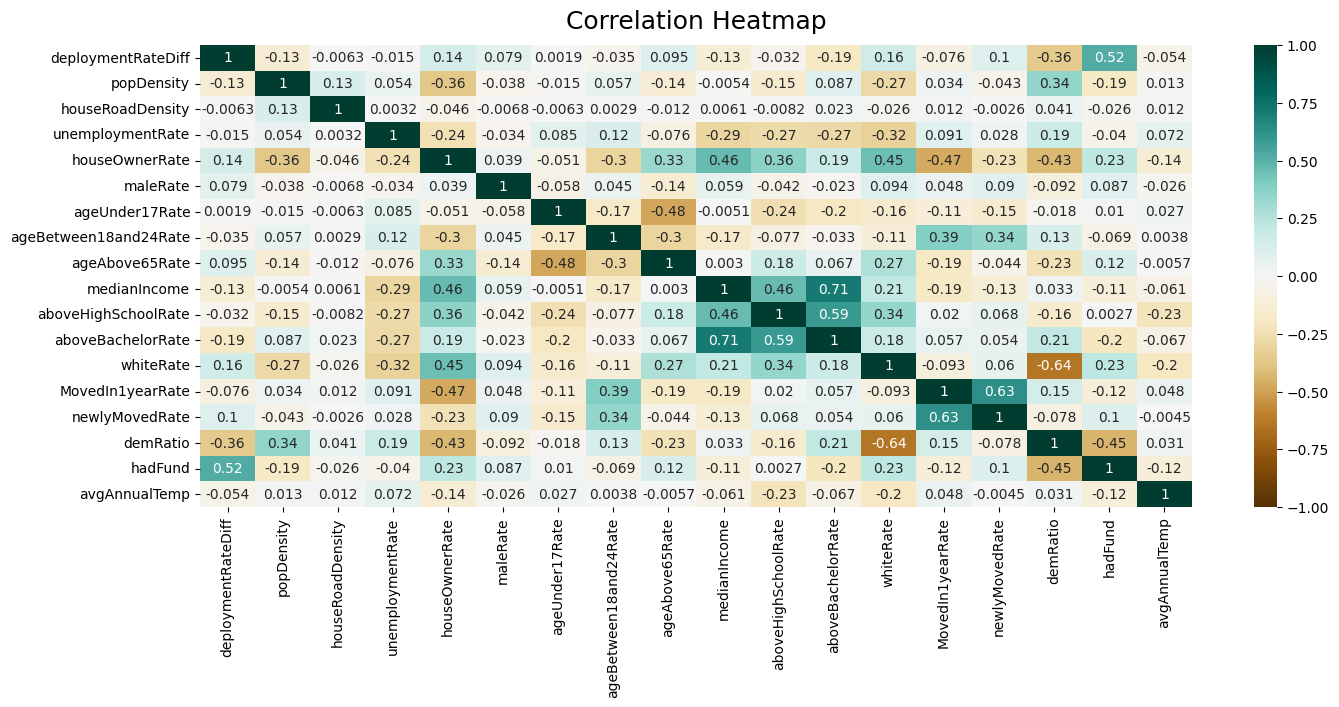

In [44]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [46]:
results = smf.ols('deploymentRateDiff ~ popDensity + houseRoadDensity + unemploymentRate + houseOwnerRate + maleRate + \
                  ageUnder17Rate + ageBetween18and24Rate + ageAbove65Rate + medianIncome + \
                  aboveHighSchoolRate + aboveBachelorRate + whiteRate + MovedIn1yearRate + \
                  newlyMovedRate + demRatio + hadFund + avgAnnualTemp', data=df).fit()

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     deploymentRateDiff   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     5162.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:56:48   Log-Likelihood:                 53311.
No. Observations:              201559   AIC:                        -1.066e+05
Df Residuals:                  201541   BIC:                        -1.064e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0383      0.000     80.599      0.000       0.037       0.039
popDensity                0.0001      0.000      0.219      0.827      -0.001       0.001
houseRoadDensity          0.0028      0.000      6.720      0.000       0.002       0.004
unemploymentRate          0.0009      0.000      1.909      0.056   -2.32e-05       0.002
houseOwnerRate            0.0040      0.001      6.070      0.000       0.003       0.005
maleRate                  0.0063      0.000     14.338      0.000       0.005       0.007
ageUnder17Rate           -0.0020      0.001     -3.592      0.000      -0.003      -0.001
ageBetween18and24Rate     0.0001      0.001      0.261      0.794      -0.001       0.001
ageAbove65Rate            0.0021      0.001      3.664      0.000       0.001       0.003
medianIncome             -0.0120      0.001    -16.677      0.000      -0.013      -0.011
aboveHighSchoolRate      -0.0069      0.001    -11.698      0.000      -0.008      -0.006
aboveBachelorRate        -0.0014      0.001     -1.775      0.076      -0.003       0.000
whiteRate                -0.0107      0.001    -16.867      0.000      -0.012      -0.009
MovedIn1yearRate         -0.0129      0.001    -20.827      0.000      -0.014      -0.012
newlyMovedRate            0.0177      0.001     31.239      0.000       0.017       0.019
demRatio                 -0.0384      0.001    -54.994      0.000      -0.040      -0.037
hadFund                   0.2409      0.001    197.073      0.000       0.238       0.243
avgAnnualTemp            -0.0029      0.000     -6.508      0.000      -0.004      -0.002
==============================================================================
Omnibus:                    87120.160   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           566999.714
Skew:                           1.973   Prob(JB):                         0.00
Kurtosis:                      10.207   Cond. No.                         5.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

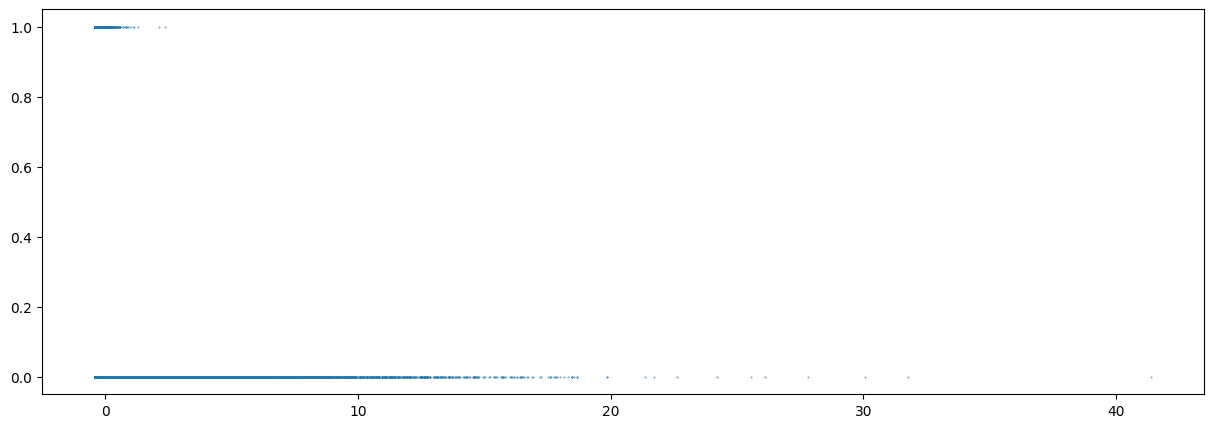

In [9]:
plt.figure(figsize=(15, 5))
plt.scatter(df['popDensity'], df['hadFund'], s = 0.1)
plt.show()

In [31]:
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod.families.links import identity

In [48]:
endog = df['deploymentRateDiff']
exog = sm.add_constant(df.iloc[:, 2:])

In [49]:
exog.min()

const                    1.000000
popDensity              -0.415900
houseRoadDensity        -0.060668
unemploymentRate        -0.954550
houseOwnerRate          -2.526108
maleRate                -7.466161
ageUnder17Rate          -2.510086
ageBetween18and24Rate   -1.110991
ageAbove65Rate          -1.658689
medianIncome            -1.769287
aboveHighSchoolRate     -7.078468
aboveBachelorRate       -1.473301
whiteRate               -2.804569
MovedIn1yearRate        -1.299735
newlyMovedRate          -0.790691
demRatio                -2.450976
hadFund                  0.000000
avgAnnualTemp           -3.229406
dtype: float64

In [50]:
exog.max()

const                      1.000000
popDensity                41.401631
houseRoadDensity         428.039322
unemploymentRate          15.870778
houseOwnerRate             1.332157
maleRate                   8.334619
ageUnder17Rate             6.498734
ageBetween18and24Rate     11.447335
ageAbove65Rate             8.102258
medianIncome               4.785392
aboveHighSchoolRate        1.067168
aboveBachelorRate          3.336690
whiteRate                  1.016012
MovedIn1yearRate           8.218431
newlyMovedRate            14.482952
demRatio                   2.136759
hadFund                    1.000000
avgAnnualTemp              2.531886
dtype: float64

In [51]:
N = len(endog)
s = 0.5
newEndog = (endog + 1) / 2
newEndog = (newEndog * (N - 1) + s) / N

In [52]:
newEndog

0         0.505370
1         0.632891
2         0.555922
3         0.951719
4         0.526921
            ...   
208943    0.500000
208944    0.500000
208946    0.500000
208948    0.500000
208949    0.500000
Name: deploymentRateDiff, Length: 201559, dtype: float64

In [53]:
mod = BetaModel(newEndog, exog)
rslt = mod.fit(method='Newton')
print(rslt.summary())

                              BetaModel Results                               
Dep. Variable:     deploymentRateDiff   Log-Likelihood:                 88031.
Model:                      BetaModel   AIC:                        -1.760e+05
Method:            Maximum Likelihood   BIC:                        -1.758e+05
Date:                Wed, 30 Nov 2022                                         
Time:                        15:57:40                                         
No. Observations:              201559                                         
Df Residuals:                  201540                                         
Df Model:                          18                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1447      0.002     84.806      0.000       0.141       0.148
popDensity         

# 2 Binary Classification

In [10]:
df['deploymentRate'] = df['deploymentRate'] == 1
df = df.astype({'deploymentRate': 'int32'})
df.describe()

,deploymentRate,popDensity,houseRoadDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,...,whiteRate,MovedIn1yearRate,newlyMovedRate,repRatio,demRatio,hadFund,avgAnnualTemp,snowResideTime,Latitute,Longitude
count,201559.000000,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,...,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,201559.000000,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05
mean,0.558750,1.156277e-16,-4.195029e-18,1.362151e-16,2.041816e-16,-1.487367e-15,8.460563e-17,-2.368958e-17,2.447923e-16,-2.538169e-17,...,-1.613147e-16,2.932995e-17,1.432655e-16,7.332488e-17,7.343768e-16,0.188654,-1.105514e-16,-7.670910e-17,8.471843e-16,-1.489059e-16
std,0.496538,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.391235,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-4.158997e-01,-6.066838e-02,-9.545499e-01,-2.526108e+00,-7.466161e+00,-2.510086e+00,-1.110991e+00,-1.658689e+00,-1.769287e+00,...,-2.804569e+00,-1.299735e+00,-7.906905e-01,-2.050441e+00,-2.450976e+00,0.000000,-3.229406e+00,-8.923495e-01,-2.615524e+00,-2.140035e+00
25%,0.000000,-3.849308e-01,-4.792107e-02,-6.616525e-01,-6.410703e-01,-5.701467e-01,-6.313289e-01,-5.212822e-01,-6.643113e-01,-6.784824e-01,...,-4.947519e-01,-7.080791e-01,-6.712394e-01,-7.684864e-01,-7.676642e-01,0.000000,-7.810800e-01,-8.923495e-01,-7.889426e-01,-4.166577e-01
50%,1.000000,-2.402631e-01,-2.907371e-02,-2.545004e-01,2.361601e-01,1.029493e-02,5.365217e-03,-1.712737e-01,-1.510577e-01,-2.281031e-01,...,3.520915e-01,-2.303183e-01,-3.227523e-01,1.817844e-02,-2.536041e-02,0.000000,-2.099294e-01,-3.336242e-01,2.354119e-01,2.453754e-01
75%,1.000000,-9.025373e-03,-5.467497e-03,3.522717e-01,8.085686e-01,5.628643e-01,6.286256e-01,2.609501e-01,4.471267e-01,4.238955e-01,...,7.845937e-01,4.564189e-01,2.949834e-01,7.663734e-01,7.603386e-01,0.000000,7.972678e-01,9.318574e-01,7.333486e-01,7.419702e-01
max,1.000000,4.140163e+01,4.280393e+02,1.587078e+01,1.332157e+00,8.334619e+00,6.498734e+00,1.144734e+01,8.102258e+00,4.785392e+00,...,1.016012e+00,8.218431e+00,1.448295e+01,2.535822e+00,2.136759e+00,1.000000,2.531886e+00,3.958822e+00,2.233326e+00,1.563378e+00


C:\Users\91952\AppData\Local\Temp\ipykernel_22220\3571524620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


Text(0.5, 1.0, 'Correlation Heatmap')

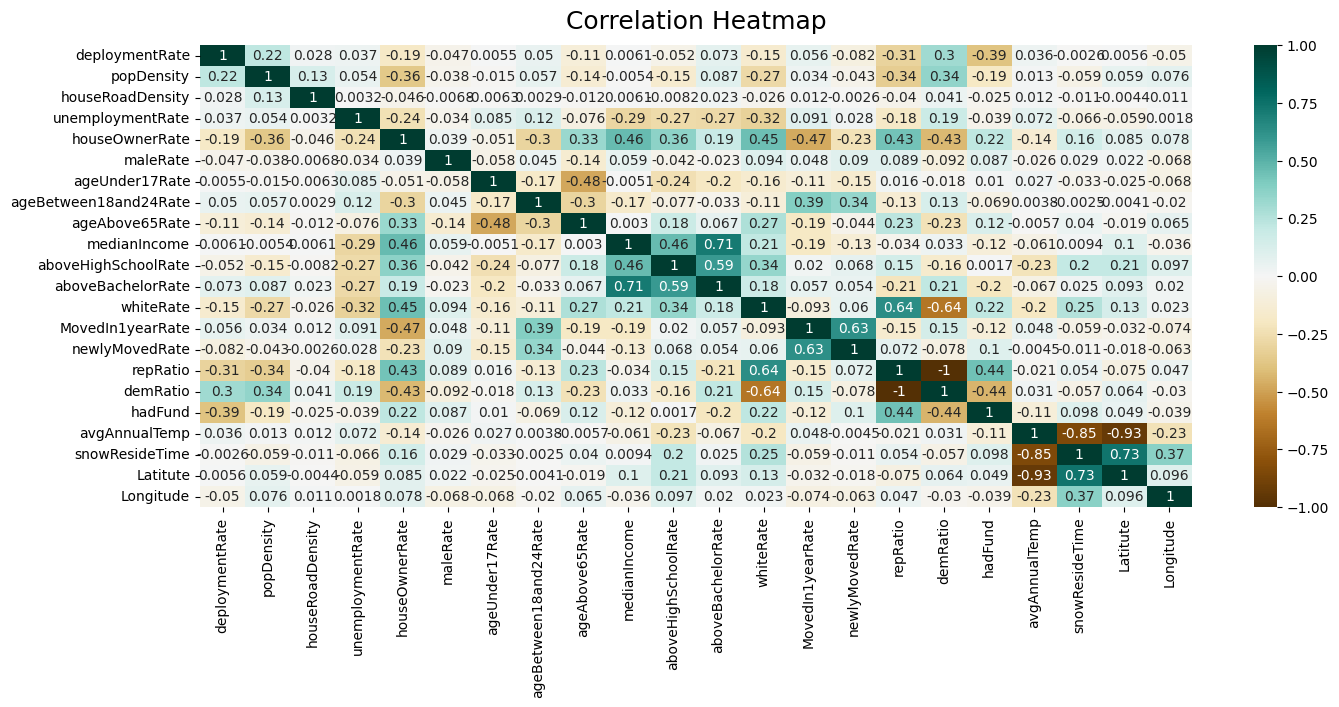

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [26]:
endog = df['hadFund']
xCol = ['popDensity', 'houseRoadDensity', 'unemploymentRate', 'houseOwnerRate', 'maleRate', 'ageUnder17Rate',
        'ageBetween18and24Rate', 'ageAbove65Rate', 'medianIncome', 'aboveHighSchoolRate', 'aboveBachelorRate', 'whiteRate',
        'MovedIn1yearRate', 'newlyMovedRate', 'repRatio', 'avgAnnualTemp', 'snowResideTime']
exog = sm.add_constant(df[xCol])

In [27]:
clf = sm.Logit(endog, exog)
results = clf.fit()
results.summary()

C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.254381
         Iterations 11


C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                hadFund   No. Observations:               201559
Model:                          Logit   Df Residuals:                   201541
Method:                           MLE   Df Model:                           17
Date:                Wed, 23 Nov 2022   Pseudo R-squ.:                  0.4747
Time:                        19:21:05   Log-Likelihood:                -51273.
converged:                       True   LL-Null:                       -97608.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.4313      0.052   -143.067      0.000      -7.533      -7.329
popDensity               -5.8357      0.213    -27.442      0.000      -6.252      -5.419
houseRoadDensity        -90.9926      1.485    -61.286      0.000     -93.903     -88.083
unemploymentRate         -0.0293      0.009     -3.262      0.001      -0.047      -0.012
houseOwnerRate            0.0665      0.015      4.307      0.000       0.036       0.097
maleRate                  0.0665      0.009      7.711      0.000       0.050       0.083
ageUnder17Rate            0.1605      0.012     13.753      0.000       0.138       0.183
ageBetween18and24Rate    -0.0242      0.012     -2.083      0.037      -0.047      -0.001
ageAbove65Rate            0.0459      0.012      3.672      0.000       0.021       0.070
medianIncome             -0.3094      0.017    -18.648      0.000      -0.342      -0.277
aboveHighSchoolRate       0.0132      0.012      1.061      0.288      -0.011       0.038
aboveBachelorRate        -0.0724      0.017     -4.155      0.000      -0.107      -0.038
whiteRate                -0.1149      0.015     -7.651      0.000      -0.144      -0.085
MovedIn1yearRate         -0.1729      0.014    -12.728      0.000      -0.200      -0.146
newlyMovedRate            0.2326      0.010     22.888      0.000       0.213       0.253
repRatio                  0.3565      0.014     25.307      0.000       0.329       0.384
avgAnnualTemp            -0.1106      0.017     -6.452      0.000      -0.144      -0.077
snowResideTime           -0.0073      0.015     -0.483      0.629      -0.037       0.022
=========================================================================================

Possibly complete quasi-separation: A fraction 0.18 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [28]:
mfx = results.get_margeff()
print(mfx.summary())

C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1843: RuntimeWarning: overflow encountered in exp
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1843: RuntimeWarning: overflow encountered in square
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1843: RuntimeWarning: invalid value encountered in divide
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:1843: Runtime

        Logit Marginal Effects       
Dep. Variable:                hadFund
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
popDensity                   nan        nan        nan        nan         nan         nan
houseRoadDensity             nan        nan        nan        nan         nan         nan
unemploymentRate             nan        nan        nan        nan         nan         nan
houseOwnerRate               nan        nan        nan        nan         nan         nan
maleRate                     nan        nan        nan        nan         nan         nan
ageUnder17Rate               nan        nan        nan        nan         nan         nan
ageBetween18and24Rate        nan        nan        nan        nan         nan         nan
ageAbove65Rate               nan      

In [117]:
clf = sm.Logit(endog, exog)
results = clf.fit()
results.summary()
mfx = results.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.609478
         Iterations 8
        Logit Marginal Effects       
Dep. Variable:         deploymentRate
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
popDensity                0.4407      0.004    100.043      0.000       0.432       0.449
unemploymentRate          0.0051      0.001      4.518      0.000       0.003       0.007
houseOwnerRate           -0.0143      0.002     -8.445      0.000      -0.018      -0.011
maleRate                 -0.0146      0.001    -13.406      0.000      -0.017      -0.012
ageUnder17Rate           -0.0093      0.001     -6.754      0.000      -0.012      -0.007
ageBetween18and24Rate     0.0018      0.001      1.391      0.164      -0.001       0.004
ageAbove65Rate           -

In [29]:
results.pred_table()

array([[153027.,  10507.],
       [ 10177.,  27848.]])

In [30]:
precision = (results.pred_table()[0, 0] + results.pred_table()[1, 1]) / np.sum(results.pred_table())
precision

0.897379923496346

## What if we use pop density only?...

In [82]:
endog = df['deploymentRate']
exog = sm.add_constant(df.iloc[:, 2])
clf = sm.Logit(endog, exog)
results = clf.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.617288
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         deploymentRate   No. Observations:               208264
Model:                          Logit   Df Residuals:                   208262
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Nov 2022   Pseudo R-squ.:                  0.1021
Time:                        14:31:15   Log-Likelihood:            -1.2856e+05
converged:                       True   LL-Null:                   -1.4318e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4344      0.006    -69.514      0.000      -0.447      -0.422
popDensity     0.0002   1.32e-06    122.658      0.000       0.000       0.000
==============================================================================
"""

In [83]:
results.pred_table()

array([[68769., 24282.],
       [37083., 78130.]])

In [84]:
precision = (results.pred_table()[0, 0] + results.pred_table()[1, 1]) / np.sum(results.pred_table())
precision

0.7053499404601852

## Maybe change some threshold?

In [99]:
df['deploymentRate'] = df['deploymentRate'] > 0.95
df = df.astype({'deploymentRate': 'int32'})
df.describe()

,deploymentRate,popDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,Latitute,Longitude
count,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000,208264.000000
mean,0.825155,6245.898981,0.056857,0.655783,0.490667,0.216245,0.088151,0.170162,68887.569345,0.874766,0.304556,0.737340,0.136587,0.049038,37.943682,-91.137042
std,0.379836,15108.145148,0.059680,0.258289,0.061150,0.086040,0.079587,0.101894,37605.601092,0.116553,0.207698,0.261349,0.105168,0.061915,4.891952,15.377054
min,0.000000,0.044621,0.000000,0.000000,0.034354,0.000000,0.000000,0.000000,2500.000000,0.045936,0.000000,0.000000,0.000000,0.000000,24.547907,-124.635404
25%,1.000000,429.557162,0.017316,0.491008,0.455788,0.161934,0.046699,0.102427,43408.500000,0.826037,0.143883,0.610177,0.062098,0.007474,34.072654,-97.592229
50%,1.000000,2602.140477,0.041597,0.717064,0.491287,0.216781,0.074469,0.155000,60286.000000,0.908672,0.252451,0.830127,0.112401,0.029028,38.995571,-86.903356
75%,1.000000,6117.372620,0.077863,0.864125,0.525076,0.270317,0.108748,0.216025,84750.000000,0.958836,0.428411,0.941590,0.184635,0.067348,41.522020,-79.936751
max,1.000000,639500.000000,1.000000,1.000000,1.000000,0.776620,0.996759,1.000000,250000.000000,1.000000,1.000000,1.000000,1.000000,0.939583,48.980788,-67.009163


In [109]:
endog = df['deploymentRate']
exog = sm.add_constant(df.iloc[:, 2:])
clf = sm.Logit(endog, exog)
results = clf.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.342005
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         deploymentRate   No. Observations:               208264
Model:                          Logit   Df Residuals:                   208248
Method:                           MLE   Df Model:                           15
Date:                Tue, 15 Nov 2022   Pseudo R-squ.:                  0.2621
Time:                        14:36:27   Log-Likelihood:                -71227.
converged:                       True   LL-Null:                       -96528.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.8382      0.120     15.344      0.000       1.603       2.073
popDensity                0.0005   4.54e-06    100.092      0.000       0.000       0.000
unemploymentRate          0.5098      0.123      4.153      0.000       0.269       0.750
houseOwnerRate           -0.9815      0.048    -20.620      0.000      -1.075      -0.888
maleRate                 -1.9381      0.117    -16.566      0.000      -2.167      -1.709
ageUnder17Rate           -0.3136      0.110     -2.842      0.004      -0.530      -0.097
ageBetween18and24Rate    -0.9138      0.119     -7.676      0.000      -1.147      -0.680
ageAbove65Rate           -0.1146      0.095     -1.210      0.226      -0.300       0.071
medianIncome           1.041e-05   3.98e-07     26.141      0.000    9.63e-06    1.12e-05
aboveHighSchoolRate      -0.1085      0.083     -1.303      0.193      -0.272       0.055
aboveBachelorRate         1.9880      0.067     29.794      0.000       1.857       2.119
whiteRate                -0.3459      0.036     -9.730      0.000      -0.416      -0.276
MovedIn1yearRate          2.9561      0.110     26.959      0.000       2.741       3.171
newlyMovedRate           -5.1435      0.139    -36.902      0.000      -5.417      -4.870
Latitute                  0.0349      0.001     24.552      0.000       0.032       0.038
Longitude                 0.0187      0.001     36.600      0.000       0.018       0.020
=========================================================================================
"""

In [112]:
mfx = results.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:         deploymentRate
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
popDensity             5.004e-05   4.65e-07    107.548      0.000    4.91e-05    5.09e-05
unemploymentRate          0.0562      0.014      4.153      0.000       0.030       0.083
houseOwnerRate           -0.1081      0.005    -20.731      0.000      -0.118      -0.098
maleRate                 -0.2135      0.013    -16.621      0.000      -0.239      -0.188
ageUnder17Rate           -0.0346      0.012     -2.843      0.004      -0.058      -0.011
ageBetween18and24Rate    -0.1007      0.013     -7.680      0.000      -0.126      -0.075
ageAbove65Rate           -0.0126      0.010     -1.210      0.226      -0.033       0.008
medianIncome           1.147e-06   4.3

In [110]:
results.pred_table()

array([[ 11463.,  24951.],
       [  4906., 166944.]])

In [111]:
precision = (results.pred_table()[0, 0] + results.pred_table()[1, 1]) / np.sum(results.pred_table())
precision

0.8566386893558177

## Maybe try more models

In [5]:
df['deploymentRate'] = df['deploymentRate'] == 1
df = df.astype({'deploymentRate': 'int32'})
df.describe()

,deploymentRate,popDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,Latitute,Longitude
count,208264.000000,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05,2.082640e+05
mean,0.553207,-9.621108e-17,2.146667e-16,-4.825566e-16,9.719367e-16,3.520916e-16,-1.310108e-17,4.730037e-16,1.195474e-16,1.084115e-15,-4.967494e-17,4.951800e-16,1.397449e-16,-1.921492e-16,2.620217e-16,-1.268349e-15
std,0.497162,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-4.134097e-01,-9.526880e-01,-2.538951e+00,-7.462199e+00,-2.513297e+00,-1.107595e+00,-1.669995e+00,-1.765364e+00,-7.111196e+00,-1.466345e+00,-2.821283e+00,-1.298752e+00,-7.920197e-01,-2.738329e+00,-2.178464e+00
25%,0.000000,-3.849805e-01,-6.625425e-01,-6.379473e-01,-5.703923e-01,-6.312292e-01,-5.208325e-01,-6.647601e-01,-6.775339e-01,-4.180838e-01,-7.735908e-01,-4.865628e-01,-7.082899e-01,-6.713129e-01,-7.913055e-01,-4.197935e-01
50%,1.000000,-2.411784e-01,-2.556869e-01,2.372578e-01,1.013108e-02,6.232353e-03,-1.719035e-01,-1.488016e-01,-2.287311e-01,2.909089e-01,-2.508718e-01,3.550303e-01,-2.299794e-01,-3.231850e-01,2.150244e-01,2.753249e-01
75%,1.000000,-8.507091e-03,3.519704e-01,8.066247e-01,5.627010e-01,6.284476e-01,2.588000e-01,4.501091e-01,4.218103e-01,7.213041e-01,5.963212e-01,7.815204e-01,4.568659e-01,2.957239e-01,7.314745e-01,7.283770e-01
max,1.000000,4.191475e+01,1.580322e+01,1.332681e+00,8.329251e+00,6.512934e+00,1.141648e+01,8.144154e+00,4.816103e+00,1.074484e+00,3.348345e+00,1.005016e+00,8.209829e+00,1.438330e+01,2.256176e+00,1.569083e+00


In [7]:
y = df['deploymentRate']
X = sm.add_constant(df.iloc[:, 2:])

### Ridge Classifier

In [12]:
clf = RidgeClassifier().fit(X, y)
clf.score(X, y)

0.6546546690738678

### Logistic Regression

In [14]:
clf = LogisticRegression(random_state=0).fit(X, y)
clf.score(X, y)

0.702987554258057

### SVM

In [31]:
clf = svm.SVC(max_iter=10000).fit(X, y)

C:\Users\91952\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [32]:
r = clf.predict(X)

In [33]:
r[r == -1] = 0

In [34]:
pred_table = np.zeros((2, 2))
for i in range(y.shape[0]):
    pred_table[y.iloc[i], r[i]] += 1
pred_table

array([[28374., 64677.],
       [43526., 71687.]])

### KNN

In [14]:
neigh = KNeighborsClassifier(n_neighbors=21).fit(X, y)

In [15]:
r = neigh.predict(X)
r[r == -1] = 0
pred_table = np.zeros((2, 2))
for i in range(y.shape[0]):
    pred_table[y.iloc[i], r[i]] += 1
pred_table

array([[63927., 29124.],
       [28715., 86498.]])

In [16]:
precision = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
precision

0.7222803749087696

## RandomForest

In [30]:
clf = RandomForestClassifier(max_depth=2)
clf.fit(X, y)

RandomForestClassifier(max_depth=2)

In [31]:
r = clf.predict(X)
r[r == -1] = 0
pred_table = np.zeros((2, 2))
for i in range(y.shape[0]):
    pred_table[y.iloc[i], r[i]] += 1
pred_table

array([[52174., 40877.],
       [15358., 99855.]])

In [32]:
precision = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
precision

0.7299821380555449

In [15]:
1. / (1. + 1e-5)

0.9999900000999989